# Import

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Import des données préfiltrées (score positif, réponses, favoris, vues) via la requête SQL suivante :**

SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount

FROM Posts 

WHERE PostTypeId = 1 AND ViewCount > 0 AND FavoriteCount > 0

AND Score > 0 AND AnswerCount > 0 AND Id < 1000000

**On effectue plusieurs requêtes en filtrant sur l'ID pour avoir environ 100.000 résultats.**

In [2]:
# Import des deux requêtes
data1 = pd.read_csv('FILTERED_QueryResults.csv')
data2 = pd.read_csv('FILTERED_QueryResults-2.csv')
data3 = pd.read_csv('FILTERED_QueryResults-3.csv')

# Concaténation
data = pd.concat([data1, data2])

# Import des données tronquées pour les tests
# data = pd.read_csv('QueryResults_NEW_LIGHT.csv')

data.head(5)

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,4,759,63751,58,12
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,<html><css><internet-explorer-7>,6,313,22512,13,7
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,<c#><.net><datetime>,9,2102,728867,485,70
3,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,11,1611,188398,552,41
4,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,13,672,247258,157,27


On supprime un certain nombre de lignes pour réduire la place dans la RAM :

In [3]:
N_LIGNES = 70000
data = data.iloc[:N_LIGNES, :]

# Nettoyage des données

### Filtrage

On choisis de supprimer certaines des lignes comme suit :

- Suppression des doublons,
- Score positif,
- Ayant des réponses.

On supprime les colonnes qui ne sont pas pertinentes.

Fonction de nettoyage du texte HTML :

In [4]:
import numpy as np

print(f'Avant : {data.shape[0]}')

# Doublons
data.drop_duplicates(inplace=True)

# Score positif
data.drop(data[data.Score < 0].index, inplace=True)

# Ayant des réponses
data.dropna(subset = ['AnswerCount'], inplace=True)
print(f'Après : {data.shape[0]}')

# Réindexaction
data.reset_index(inplace=True)

# Suppression de certaines colonnes pour alléger le dataframe
data.drop(['index', 'Id', 'Score', 'ViewCount', 'AnswerCount', 'FavoriteCount'], axis=1, inplace=True)

# Affichage
data.head(5)

Avant : 70000
Après : 70000


,Title,Body,Tags
0,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,<html><css><internet-explorer-7>
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,<c#><.net><datetime>
3,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...
4,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...


La filtrage n'a plus d'impact sur les données d'entrée car elles ont déjà été filtrées par SQL.

### Valeurs manquantes

In [5]:
# Calcul des valeurs manquantes sur chaque colonne
isna_body = data['Body'].isna().sum()
isna_title = data['Title'].isna().sum()
isna_tag = data['Tags'].isna().sum()

# Ratios en %
isna_body = round(isna_body*100/data.shape[0], 2)
isna_title = round(isna_title*100/data.shape[0], 2)
isna_tag = round(isna_tag*100/data.shape[0], 2)

# Affichage
print(f'Pourcentage de NaN Body = {isna_body}%\n',
      f'\rPourcentage de NaN Title = {isna_title}%\n',
      f'\rPourcentage de NaN Tag = {isna_tag}%\n')

Pourcentage de NaN Body = 0.0%
Pourcentage de NaN Title = 0.0%
Pourcentage de NaN Tag = 0.0%



### Traitement des tags

On cherche ici à parser les tags entre chevrons et à les transformer en simples listes de mots.

In [6]:
def parsingTags(tags):
    
    # En enlève le premier et le dernier chevron
    tags = tags[1:-1]
    
    # On sépare le string par "><"
    tags = tags.split('><')
    
    # Retour
    return tags

Application de la fonction et aperçu :

In [7]:
data['Tags'] = data['Tags'].apply(parsingTags)
data.head(5)

,Title,Body,Tags
0,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,"[c#, floating-point, type-conversion, double, ..."
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,"[html, css, internet-explorer-7]"
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,"[c#, .net, datetime]"
3,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,"[c#, datetime, time, datediff, relative-time-s..."
4,Determine a user's timezone,<p>Is there a standard way for a web server to...,"[html, browser, timezone, user-agent, timezone..."


Maintenant que nous avons les tags sous forme de liste pour chaque ligne, nous décidons de ne conserver que les tags les plus fréquents en effectuant les opérations suivantes :

- Création d'une liste totale de tous les tags du dataframe par concaténation des listes de toutes les lignes,
- Comptage des occurences des tags sur tout le dataframe,
- Suppression des tags qui apparaissent moins de SEUIL fois,
- Affichage de la répartition des tags retenus,
- Création d'une liste unique des tags les plus fréquents.

Seuil du nombre d'apparitions d'un tag pour qu'il soit retenu :

In [8]:
SEUIL_TAGS = 500

Application du tri :

10729 tags en entrée


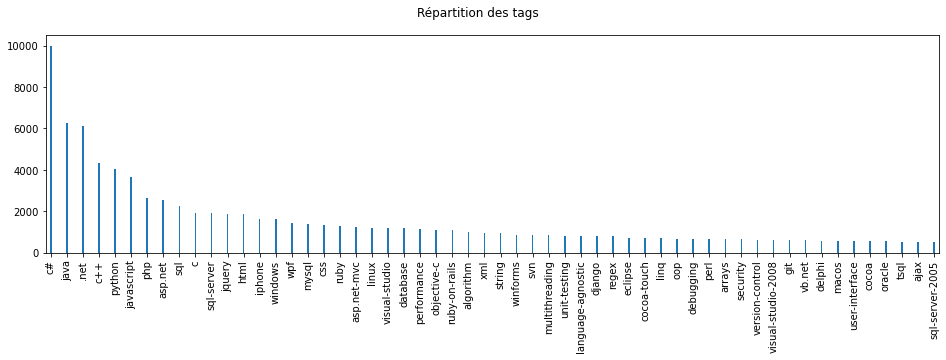

56 tags en sortie


,Title,Body,Tags
0,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,"[c#, floating-point, type-conversion, double, ..."
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,"[html, css, internet-explorer-7]"
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,"[c#, .net, datetime]"
3,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,"[c#, datetime, time, datediff, relative-time-s..."
4,Determine a user's timezone,<p>Is there a standard way for a web server to...,"[html, browser, timezone, user-agent, timezone..."


In [9]:
import matplotlib.pyplot as plt

# Concaténation de tous les tags du dataframe
totalTags = []
for index, x in data.iterrows():
    totalTags = totalTags + x['Tags']

# Nombre total de tags en entrée
print(f'{len(set(totalTags))} tags en entrée')

# Conversion en dataframe pour l'affichage du bargraph
totalTags = pd.DataFrame(totalTags, columns=['Tags'])

# On supprime les tags qui apparraissent peu
counts = totalTags['Tags'].value_counts()
totalTags = totalTags[~totalTags['Tags'].isin(counts[counts < SEUIL_TAGS].index)]

# Affichage
fig, axes = plt.subplots(figsize=(16, 4))
fig.suptitle('Répartition des tags')
totalTags['Tags'].value_counts(normalize=False).plot(kind='bar', width=0.1)
plt.show()

# Concaténation des tags retenus
tagsRetenus = []
for index, x in totalTags.iterrows():
    tagsRetenus.append(x['Tags'])

# Création d'une liste unique de tags retenus
tagsRetenus = list(set(tagsRetenus))

# Nombre total de tags en sortie
print(f'{len(tagsRetenus)} tags en sortie')

data.head(5)

Ensuite, une fonction de suppression des ces tags sur toutes les lignes est créée et appliquée :

In [10]:
def suppressionTags(tags):
    return list(set(tags).intersection(set(tagsRetenus)))

data['Tags'] = data['Tags'].apply(suppressionTags)
data.head(5)

,Title,Body,Tags
0,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,[c#]
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,"[css, html]"
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,"[.net, c#]"
3,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,[c#]
4,Determine a user's timezone,<p>Is there a standard way for a web server to...,[html]


Enfin, on supprime les lignes qui ne contiennent plus de tags :

In [11]:
indexSuppr = []
for i, x in data.iterrows():
    if data.iloc[i, 2] == []:
        indexSuppr.append(i)

s1 = data.shape[0]

data = data.drop(index=indexSuppr)  
data.reset_index(inplace=True)

s2 = data.shape[0]
print(f'{s1-s2} individus supprimés ({s1} → {s2})')
data.drop(['index'], axis=1, inplace=True)
data.head(5)

12370 individus supprimés (70000 → 57630)


,Title,Body,Tags
0,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,[c#]
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,"[css, html]"
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,"[.net, c#]"
3,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,[c#]
4,Determine a user's timezone,<p>Is there a standard way for a web server to...,[html]


### Traitement du texte

Import d'un dictionnaire de mots relatifs à la programmation informatique. Ce sont des mots importants, par exemple ceux relatifs à des langages de programmation, qui nous aideront pour cibler nos tags :

In [12]:
import numpy as np
filename = 'dicoProgramming.txt'

# Récupération des mots du fichier texte
texte = []
with open(filename, 'r') as f:
    for line in f.readlines():
        texte.append(line.replace("\n", ""))

# Mise en minuscule
dictionnaireInfo = []
for i in range(len(texte)):
    dictionnaireInfo.append(texte[i].lower())

On va maintenant nettoyer le texte des champs Body et Title en effectuant les actions suivantes :

- Suppression des balises HTML avec BeautifulSoup,
- Mise en minuscule,
- Suppression des liens hypertexte,
- Suppression des mots qui ne sont pas dans le dictionnaire ou qui ne sont pas reliés à l'informatique,
- Suppression des contractions,
- Retrait des nombres et de la ponctuation,
- Retrait des caractères isolés qui en résultent ('s, 't, etc) sauf la lettre C qui est un langage de programmation,
- Retrait des stopwords,
- Stemming et Lemming des mots (on ne garde que la lemme). "trying" devient "try" par exemple.
- Retrait des espaces en trop qui résulteraient des précédentes opérations.
- Suppression des adjectifs et adverbes.

In [13]:
from bs4 import BeautifulSoup
import re
import html as ihtml
import nltk
import contractions

"""nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('omw-1.4')"""

# Mots du dictionnaire anglais
from nltk.corpus import words
dictionnaire = words.words()

# Ajout des mots relatifs à l'informatique
dictionnaire = dictionnaire + dictionnaireInfo

import gensim
from gensim.parsing.preprocessing import STOPWORDS as stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import RegexpTokenizer
from autocorrect import Speller
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer

# Transformation des stopwords en liste
stopwords = list(stopwords)

# Regex qui ne conserve que les lettres
tokenizerLettres = RegexpTokenizer(r'[a-z]+')

# Alphabet sans la lettre c (langage de programmation)
alphabetSansC = ['a', 'b', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
                 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
                 'v', 'w', 'x', 'y', 'z']

# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialisation du stemmer
# stemmer = PorterStemmer()
stemmer = SnowballStemmer(language='english')

# Initialisation du correcteur
spell = Speller(lang='en')


# Retrait des stopwords
def removeWords(text, words):
    
    # Tokenisation du texte
    text = nltk.word_tokenize(text)
    # Retrait des stopwords en passant par des sets
    text = list(set(text) - set(words))
    # Regroupement du textes
    text = " ".join(text)
    return text


# Conservation uniquement des mots du dictionnaire
def motsCorrects(text):
    
    # Tokenisation du texte
    text = nltk.word_tokenize(text)
    # On garde uniquement les mots du dictionnaire
    text = list(set(text) & set(dictionnaire))
    # Regroupement du textes
    text = " ".join(text)
    return text


# Lemmatizaion des mots en fonction de leur type (nom, verbe, etc)
def lemmatize_text(text):
    
    # Découpage des mots en liste associé au tag du type de mot
    tokens_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    
    # Vecteur du texte lemmatisé
    lemmatized_text = []
    
    # Boucle sur les mots et leurs tags
    for word, tag in tokens_tagged:
        # Adjectifs
        if tag.startswith('J'):
            # lemmatized_text.append(lemmatizer.lemmatize(word, 'a'))
            lemmatized_text.append('')
        # Adverbes
        elif tag.startswith('R'):
            # lemmatized_text.append(lemmatizer.lemmatize(word, 'r'))
            lemmatized_text.append('')
        # Verbes
        elif tag.startswith('V'):
            lemmatized_text.append(lemmatizer.lemmatize(word, 'v'))
        # Noms
        elif tag.startswith('N'):
            lemmatized_text.append(lemmatizer.lemmatize(word, 'n'))
        # Lematization simple pour le reste
        else:
            lemmatized_text.append(lemmatizer.lemmatize(word))
    
    # Recollement du texte
    return " ".join(lemmatized_text)


# Stemming du texte
def stemming_text(text):

    text = nltk.word_tokenize(text)
    stem_text = []
    for word in text:
        stem_text.append(stemmer.stem(word))
    return " ".join(stem_text)


# Retrait des contractions et du slang
def suppressionContractions(text):

    # Tokenisation du texte
    text = contractions.fix(text)
    return text


# Fonction de nettoyage du texte qui regroupe plusieurs opérations
def clean_text(text):
    
    # Retrait du HTML par BeautifulSoup
    text = BeautifulSoup(ihtml.unescape(text)).text
    
    # Mise en minuscule
    text = text.lower()
    
    # Retrait des liens
    text = re.sub(r"http[s]?://\S+", "", text)
    
    # Retrait des contractions (doesn't) avant la ponctuation
    text = suppressionContractions(text)
    
    # Retrait des lettres seules sauf le C
    text = removeWords(text, alphabetSansC)
    
    # On ne garde que les mots de la langue anglaise
    text = motsCorrects(text)
    
    # Retrait de la ponctuation
    text = tokenizerLettres.tokenize(text)
    text = " ".join(text)
    
    # Correction de l'orthographe (très couteux en ressources)
    # text = spell(text)
    
    # Stemming des mots
    # text = stemming_text(text)
    
    # Lemmatisation des mots
    text = lemmatize_text(text)
    
    # Retrait des stopwords
    text = removeWords(text, stopwords)
    
    # Retrait des espaces en trop 
    text = re.sub(r"\s+", " ", text)
    
    # Retour
    return text

Affichage des stopwords :

In [14]:
print(len(stopwords))
print(sorted(stopwords))

337
['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', '

Application de la fonction et exemple :

In [15]:
# Ligne 1 avant traitement
print('\033[1mAvant traitement\033[0m :', data['Title'][0])
print()
print(data['Body'][0])

# Application de la fonction de nettoyage du texte
data['Body'] = data['Body'].apply(clean_text)
data['Title'] = data['Title'].apply(clean_text)

# Ligne 1 après traitement
print()
print('\033[1mAprès traitement\033[0m :', data['Title'][0])
print()
print(data['Body'][0])

Avant traitement : How to convert a Decimal to a Double in C#?

<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>'s opacity.</p>
<p>This is my code:</p>
<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;
this.Opacity = trans;
</code></pre>
<p>When I build the application, it gives the following error:</p>
<blockquote>
<pre class="lang-none prettyprint-override"><code>Cannot implicitly convert type decimal to double
</code></pre>
</blockquote>
<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn't work. This code worked fine in a past VB.NET project.</p>


Après traitement : decimal double convert c

opacity past use change code fine try want build error follow control work project application form


Vérification de l'extraction des contractions :

In [16]:
print(suppressionContractions("doesn't"))

does not


Concaténation des colonnes Body et Title qui contiennent les mots. Pas de réelle nécessité de discerner les deux.

In [17]:
data['TitleBody'] = data['Title'] + ' ' + data['Body']

On supprime les lignes au TitleBody vide :

In [18]:
indexSuppr = []
for i, x in data.iterrows():
    if x['Title'] == '' and x['Body'] == '':
        indexSuppr.append(i)

s1 = data.shape[0]

data = data.drop(index=indexSuppr)
data.reset_index()

s2 = data.shape[0]
print(f'{s1-s2} individus supprimés ({s1} → {s2})')

21 individus supprimés (57630 → 57609)


Suppression des colonnes Title et Body, on va travailler sur TitleBody seulement pour plus de simplicité :

In [19]:
data.drop(['Title', 'Body'], axis=1, inplace=True)
data.head(5)

,Tags,TitleBody
0,[c#],decimal double convert c opacity past use chan...
1,"[css, html]",percentage explorer parent collapse width chil...
2,"[.net, c#]",birthday base calculate age type birthday repr...
3,[c#],c time calculate time like day display month v...
4,[html],user determine page way string user server web...


# Extraction de features

### Texte

Création du corpus :

In [20]:
# Concaténation de toutes les chaines de caractère du dataframe
# Ou de toute les lignes pour faire le countvectorizer
corpus_LIGNES = []
corpus_MOTS = []
for i, x in data.iterrows():
    mots = nltk.word_tokenize(x['TitleBody'])
    corpus_MOTS = corpus_MOTS + mots
    corpus_LIGNES.append(x['TitleBody'])

Affichage du corpus des mots **après filtrage** dans l'ordre alphébatique :

In [21]:
# Affichage
LONGUEUR_CORPUS = len(set(corpus_MOTS))
print(LONGUEUR_CORPUS)
print(sorted(set(corpus_MOTS)))

10277
['aa', 'aardvark', 'aba', 'aback', 'abacus', 'abandon', 'abb', 'abbreviation', 'aberrant', 'aberration', 'abhor', 'abide', 'abiding', 'ability', 'abject', 'abnormal', 'aboard', 'abomination', 'abort', 'abortion', 'abound', 'abridge', 'abrupt', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorption', 'abstract', 'abstraction', 'absurd', 'abuse', 'abusive', 'abut', 'aby', 'academic', 'academy', 'accelerate', 'acceleration', 'accelerator', 'accelerometer', 'accent', 'accept', 'acceptable', 'acceptance', 'accepter', 'acception', 'acceptor', 'access', 'accessibility', 'accessible', 'accessory', 'accident', 'accidental', 'acclimate', 'accommodate', 'accommodation', 'accompany', 'accomplish', 'accomplished', 'accord', 'accordance', 'accordingly', 'accordion', 'account', 'accountability', 'accountancy', 'accounting', 'accumulate', 'accumulation', 'accumulator', 'accuracy', 'accurate', 'accusation', 'accuse', 'accustom', 'ace', 'ach', 'achieve', 'achievement', 'achor', 'acid

Affichage du corpus des lignes dans l'ordre du dataframe :

In [22]:
print(len(corpus_LIGNES))
# print(corpus_LIGNES)

57609


On va maintenant extraire des features de ce corpus.
On considère le seuil N comme le nombre minimum de l'apparition d'un mot dans le corpus pour qu'il soit pris en compte dans l'encodage des résultats. Cela permet de filtrer les mots peu utilisés, similairement à ce que l'on a fait pour les tags.

In [23]:
# On filtre les mots qui apparaissent seulement plus de X fois
SEUIL_MIN = 2

# On filtre les mots qui apparaissent dans X% des cas
SEUIL_MAX = 0.5

On crée des fonctions d'extraction de features :

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


def extractVectorizer(lignes, SEUIL_MIN, SEUIL_MAX, *args):

    try:    
        vectorizer = CountVectorizer(min_df=SEUIL_MIN, max_df=SEUIL_MAX, max_features=args[0])
    except:
        vectorizer = CountVectorizer(min_df=SEUIL_MIN, max_df=SEUIL_MAX)
    
    count_matrix = vectorizer.fit_transform(corpus_LIGNES)
    count_array = count_matrix.toarray()
    return pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names_out())


def extractTFIDF(lignes, SEUIL_MIN, SEUIL_MAX, *args):
    
    try:
        vectorizer = TfidfVectorizer(min_df=SEUIL_MIN, max_df=SEUIL_MAX, max_features=args[0])
    except:
        vectorizer = TfidfVectorizer(min_df=SEUIL_MIN, max_df=SEUIL_MAX)
    
    vectors = vectorizer.fit_transform(corpus_LIGNES)
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors.todense()
    denselist = dense.tolist()
    return pd.DataFrame(denselist, columns=feature_names)

Application des fonctions :

In [25]:
dataCount = extractVectorizer(corpus_LIGNES, SEUIL_MIN, SEUIL_MAX)
dataTF = extractTFIDF(corpus_LIGNES, SEUIL_MIN, SEUIL_MAX)

print(f'{dataCount.shape[0]}x{dataCount.shape[1]}')
print(f'{dataTF.shape[0]}x{dataTF.shape[1]}')

57609x7160
57609x7160


### Tags

One hot encoding des tags :

In [26]:
# Encodage des tags multilabel
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
resultat = mlb.fit_transform(data['Tags'])
dataTags = pd.DataFrame(resultat)
dataTags.columns = mlb.classes_
print(f'{dataTags.shape[0]}x{dataTags.shape[1]}')
dataTags.head(5)

57609x56


,.net,ajax,algorithm,arrays,asp.net,asp.net-mvc,c,c#,c++,cocoa,cocoa-touch,css,database,debugging,delphi,django,eclipse,git,html,iphone,java,javascript,jquery,language-agnostic,linq,linux,macos,multithreading,mysql,objective-c,oop,oracle,performance,perl,php,python,regex,ruby,ruby-on-rails,security,sql,sql-server,sql-server-2005,string,svn,tsql,unit-testing,user-interface,vb.net,version-control,visual-studio,visual-studio-2008,windows,winforms,wpf,xml
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# ACP

Afin de réduire la dimension, on affiche l'éboulis aux valeurs propres du problème, via une fonction.

In [27]:
# Import des librairies
from sklearn import decomposition
from sklearn import preprocessing
from fonctionsACP import *


def affichageEboulis(n_comp, data):

    # Export des colonnes quantitatives
    data_pca = data

    # Exctraction des données d'analyse
    X = data_pca.values
    names = data_pca.index
    features = data_pca.columns

    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    # Calcul des composantes principales (PCA)
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)

    # Eboulis des valeurs propres
    display_scree_plot(pca)

Application de la fonction aux deux bag of words :

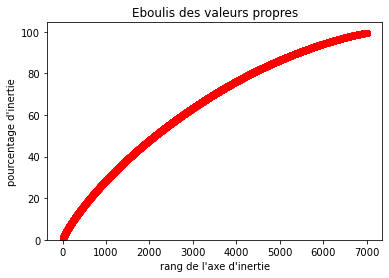

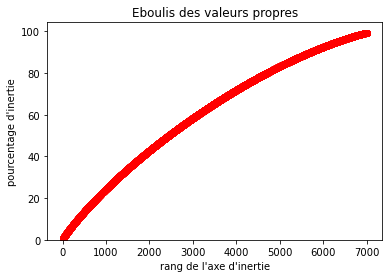

In [28]:
# Nombre de composantes principales
n_comp = 7000

# Application de la fonction
affichageEboulis(n_comp, dataCount)
affichageEboulis(n_comp, dataTF)

Basé sur ces résultats, on refait une extraction de features avec un compromis entre la variabilité et le nombre de features (3000) :

In [29]:
dataCount = extractVectorizer(corpus_LIGNES, SEUIL_MIN, SEUIL_MAX, 3000)
dataTF = extractTFIDF(corpus_LIGNES, SEUIL_MIN, SEUIL_MAX, 3000)

# Sauvegarde

Concaténation des tags :

In [30]:
# Countvectorizer
dataCountTags = pd.concat([dataCount, dataTags], axis=1)
print(f'{dataCount.shape[0]}x{dataCount.shape[1]}')
print(f'{dataCountTags.shape[0]}x{dataCountTags.shape[1]}')

# TF-IDF
dataTFTags = pd.concat([dataTF, dataTags], axis=1)
print(f'{dataTF.shape[0]}x{dataTF.shape[1]}')
print(f'{dataTFTags.shape[0]}x{dataTFTags.shape[1]}')

57609x3000
57609x3056
57609x3000
57609x3056


Export sans la colonne d'index :

In [31]:
data.to_csv('dataRaw.csv', index=False)
dataCount.to_csv('CountVectorizer.csv', index=False)
dataCountTags.to_csv('CountVectorizerTags.csv', index=False)
dataTF.to_csv('TF-IDF.csv', index=False)
dataTFTags.to_csv('TF-IDFTags.csv', index=False)